In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt

import add_path
import toolkit.allen_helpers.stimuli as st
import toolkit.pipeline.signal as ps
from toolkit.plots import plots
from toolkit.pipeline.global_settings import GLOBAL_SETTINGS
from toolkit.pipeline.data_io import get_existing_sessions, get_session_selection, SessionDirectory, format_for_path
from toolkit.pipeline.signal import average_psd_across_sessions
from toolkit.paths import paths
from toolkit.plots.format import SAVE_FIGURE, save_figure

In [2]:
# from toolkit.utils.module import reload_module

## Config

In [3]:
session_set = 'test'  # 'all', 'selected', 'test'

ecephys_structure_acronym = GLOBAL_SETTINGS['ecephys_structure_acronym']

# get existing sessions in the data cache directory
session_list, missing_sessions = get_existing_sessions(session_set, structure_acronym=ecephys_structure_acronym)

sessions_df = get_session_selection().loc[session_list]
session_list = sessions_df.index[sessions_df['has_lfp_data']].tolist()

In [4]:
figsize = (3.6, 3.0)
plt_range = 100.  # PSD frequency range for plotting

condition_wave_band = GLOBAL_SETTINGS['condition_wave_band']

## Load data

In [5]:
psd_dss = {}
cond_psd_das = {}
bands_dss = {}
# cond_band_power_das = {}
preferred_orientations = {}

session_types = {s: [] for s in sessions_df['session_type'].unique()}

for session_id in session_list:
    session_dir = SessionDirectory(session_id, ecephys_structure_acronym)

    # load PSD
    if not session_dir.exist:
        print(f"Failed to load PSD for session {session_id}: session directory does not exist")
    elif not session_dir.has_lfp_data: # skip if no lfp data
        print(f"Failed to load PSD for session {session_id}: no lfp data")
    else:
        session_type = sessions_df.loc[session_id, 'session_type']
        psd_dss[session_id] = session_dir.load_psd()[0]
        cond_psd_das[session_id] = session_dir.load_conditions_psd()
        bands_dss[session_id] = session_dir.load_bands()
        # cond_band_power_das[session_id] = session_dir.load_condition_band_power(
        #     wave_band=condition_wave_band, session_type=session_type)
        preferred_orientations[session_id] = session_dir.load_preferred_orientations(condition_wave_band)
        session_types[session_type].append(session_id)

session_list = list(psd_dss)

In [6]:
fss = np.array([ds.attrs['fs'] for ds in psd_dss.values()])
fs = np.round(np.median(fss))  # round to integer sampling rate

# check if all sampling rates are the same
if np.any(np.round(fss) != fs):
    raise ValueError(f'Inconsistent sampling rate found.')

nfft = next(iter(psd_dss.values())).attrs['nfft']
# check if all nffts are the same
if any(ds.attrs['nfft'] != nfft for ds in psd_dss.values()):
    raise ValueError(f'Inconsistent nfft found.')

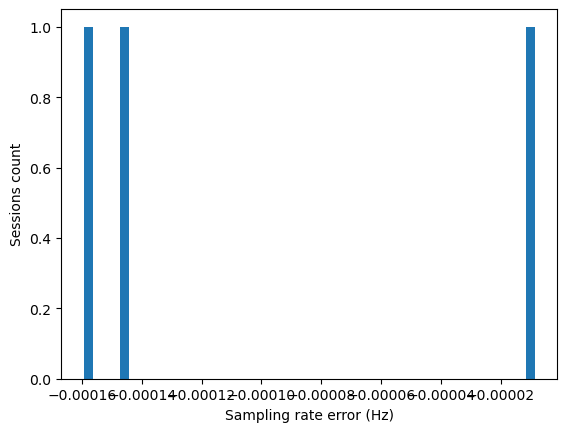

In [7]:
plt.hist(fss - fs, bins=50)
plt.xlabel('Sampling rate error (Hz)')
plt.ylabel('Sessions count')
plt.show()

## Analyze data

### Average PSD across sessions

In [8]:
psd_avg = {}
psd_ds = {}
cond_psd_ds = {}
cond_psd_avg = {}
bands_ds = {}

for session_type, session_ids in session_types.items():
    # average PSD across sessions
    psd_avg[session_type], psd_ds[session_type] = average_psd_across_sessions(
        (psd_dss[session_id] for session_id in session_ids), fs=fs, nfft=nfft
    )

    # average drifting gratings conditions PSD across sessions
    for stim in st.STIMULUS_CATEGORIES[session_type]['drifting_gratings']:
        cond_psd_avg[stim], cond_psd_ds[stim] = average_psd_across_sessions(
            (cond_psd_das[session_id][stim] for session_id in session_ids), fs=fs, nfft=nfft
        )

    # combine bands of sessions
    bands_ds[session_type] = xr.concat(
        (bands_dss[session_id] for session_id in session_ids),
        data_vars=['bands', 'peaks', 'center_freq'],
        dim=pd.Index(session_ids, name='session_id')
    )

### FOOOF Analysis

#### Fooof parameters

In [9]:
ds = list(bands_ds.values())[0]
fooof_params = {k: ds.attrs[k] for k in [
    'freq_range', 'aperiodic_mode', 'peak_width_limits', 'max_n_peaks', 'dB_threshold', 'peak_threshold'
]}

wave_band_limit = ds.data_vars['wave_band_limit']
wave_band_width_limit = ds.data_vars['wave_band_width_limit']
freq_band_kwargs = {k: ds.attrs[k] for k in ['top_n_peaks', 'bandwidth_n_sigma']}

#### Fit FOOOF and get frequency bands

In [10]:
fooof_objs = {}
avg_bands_ds = {}

for session_type in session_types:
    fooof_objs[session_type], avg_bands_ds[session_type] = ps.fit_fooof_and_get_bands(
        psd_avg[session_type], fooof_params, freq_band_kwargs, wave_band_limit, wave_band_width_limit)

Knee location: 0.34 Hz


c:\Users\ziaochen\projects\neuroscience\Analyzing_Allen_Visual_Coding_Neuropixels_Dataset\toolkit\analysis\spectrum.py:149: UserWarning: Negative value of knee parameter occurred. Re-fit without knee parameter.
  warnings.warn("Negative value of knee parameter occurred. Re-fit without knee parameter.")


Knee location: 0.09 Hz


c:\Users\ziaochen\projects\neuroscience\Analyzing_Allen_Visual_Coding_Neuropixels_Dataset\toolkit\analysis\spectrum.py:149: UserWarning: Negative value of knee parameter occurred. Re-fit without knee parameter.
  warnings.warn("Negative value of knee parameter occurred. Re-fit without knee parameter.")


#### Get band power in drifting grating conditions

In [11]:
cond_band_power_das = {}
layer_bands_ds = {}
for stim, cond_psd in cond_psd_avg.items():
    session_type = st.STIMULUS_SESSION_TYPES[stim]
    cond_band_power_das[stim], layer_bands_ds[stim] = ps.layer_condition_band_power(
        cond_psd.sel(stimulus=stim), avg_bands_ds[session_type].bands.sel(stimulus=stim),
        wave_band_limit, st.FIXED_CONDITION_TYPES[session_type], condition_wave_band=condition_wave_band
    )

### Convert frequency bands to table

In [12]:
bands_ds['brain_observatory_1.1']

<xarray.Dataset>
Dimensions:                (stimulus: 11, session_id: 1, layer: 5,
                            wave_band: 3, bound: 2, peak_rank: 2)
Coordinates:
  * stimulus               (stimulus) object 'spontaneous' ... 'drifting_grat...
  * layer                  (layer) object '1' '2/3' '4' '5' '6a'
  * wave_band              (wave_band) object 'beta' 'gamma' 'LGN gamma'
  * bound                  (bound) object 'lower' 'upper'
  * peak_rank              (peak_rank) int32 0 1
  * session_id             (session_id) int64 721123822
Data variables:
    bands                  (session_id, stimulus, layer, wave_band, bound) float64 ...
    peaks                  (session_id, stimulus, layer, wave_band, peak_rank) float64 ...
    center_freq            (session_id, stimulus, layer, wave_band, peak_rank) float64 ...
    wave_band_limit        (wave_band, bound) float64 20.0 40.0 ... 50.0 70.0
    wave_band_width_limit  (wave_band, bound) float64 0.0 30.0 5.0 20.0 0.0 10.0
Attributes:
    peak_width_limits:  [ 0. inf]
    min_peak_height:    0.08
    peak_threshold:     1.0
    max_n_peaks:        10
    aperiodic_mode:     knee
    freq_range:         200.0
    dB_threshold:       0.8
    top_n_peaks:        2
    bandwidth_n_sigma:  1.5

## Visualize PSDs

In [13]:
if SAVE_FIGURE:
    fig_dir = paths.FIGURE_DIR / "Average_PSD"
    cond_psd_dir = fig_dir / f"condition_psd"
    cond_band_power_dir = fig_dir / f"condition_{condition_wave_band}_power"
    layer_psd_dir = fig_dir / "layer_psd"
    fooof_dir = fig_dir / "fooof"

    fig_dir.mkdir(parents=True, exist_ok=True)
    cond_psd_dir.mkdir(parents=True, exist_ok=True)
    cond_band_power_dir.mkdir(parents=True, exist_ok=True)
    layer_psd_dir.mkdir(parents=True, exist_ok=True)
    fooof_dir.mkdir(parents=True, exist_ok=True)

### Plot average PSD of drifting gratings conditions

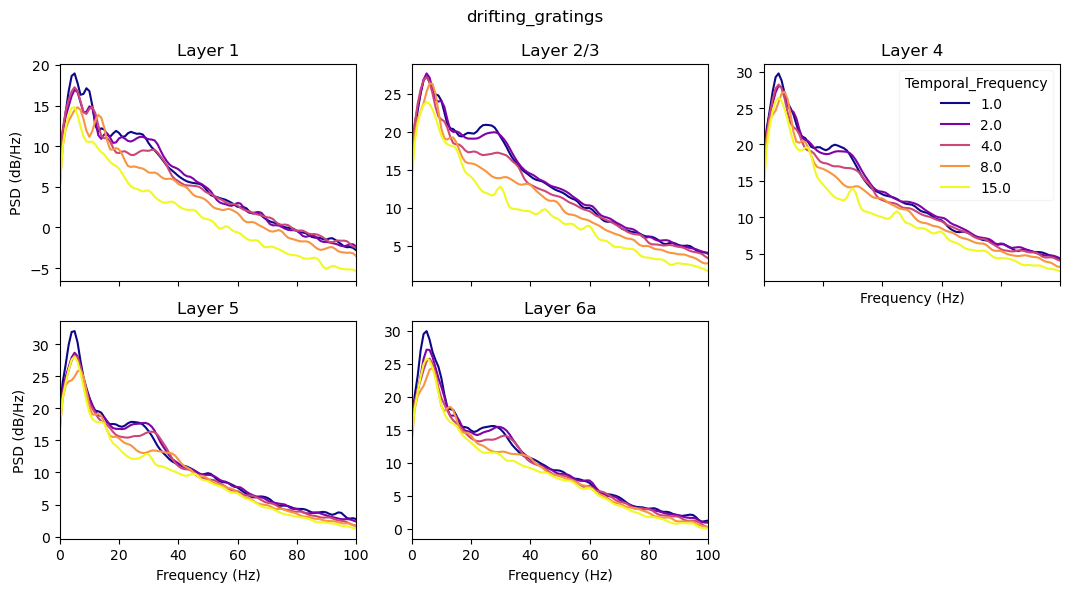

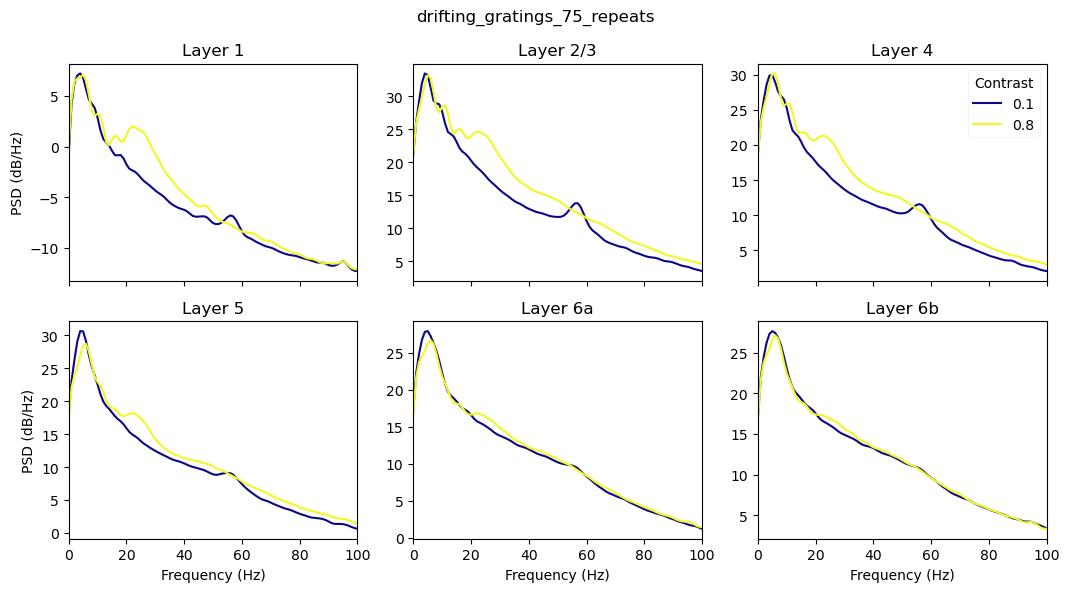

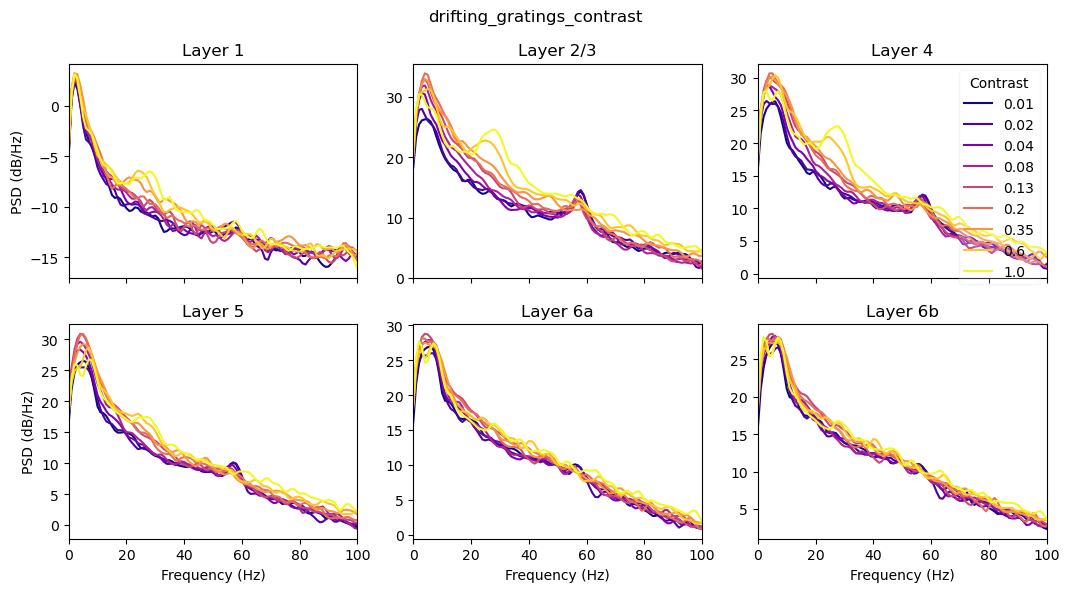

In [14]:
n_cols = 3
average_over = 'orientation'
condition_types = st.CONDITION_TYPES

for stim, da in cond_psd_avg.items():
    session_type = st.STIMULUS_SESSION_TYPES[stim]
    average_dims = st.FIXED_CONDITION_TYPES[session_type] + (average_over,)
    channel_dim = np.setdiff1d(condition_types, average_dims)[0]
    avg_da = da.mean(dim=average_dims)

    layers = avg_da.coords['layer'].values
    n_layers = len(layers)
    n_rows = np.ceil(n_layers / n_cols).astype(int)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(figsize[0] * n_cols, figsize[1] * n_rows),
        sharex=True, squeeze=False)
    for i, layer in enumerate(layers):
        ax = axs.ravel()[i]
        layer_da = avg_da.sel(layer=layer, stimulus=stim)
        plots.plot_channel_psd(layer_da, channel_dim=channel_dim, freq_range=plt_range, ax=ax)
        ax.set_title(f'Layer {layer}')

    for ax in axs.ravel()[n_layers:]:
        ax.remove()
    for ax in axs.ravel()[:n_layers]:
        if ax is not axs[0, -1]:
            ax.get_legend().remove()
    for ax in axs[:, 1:].ravel():
        ax.set_ylabel('')
    for ax in axs.ravel()[:n_layers - n_cols]:
        ax.set_xlabel('')
    fig.suptitle(stim)
    fig.tight_layout()

    if SAVE_FIGURE:
        save_figure(cond_psd_dir, fig, name=stim)
    plt.show()

drifting_gratings


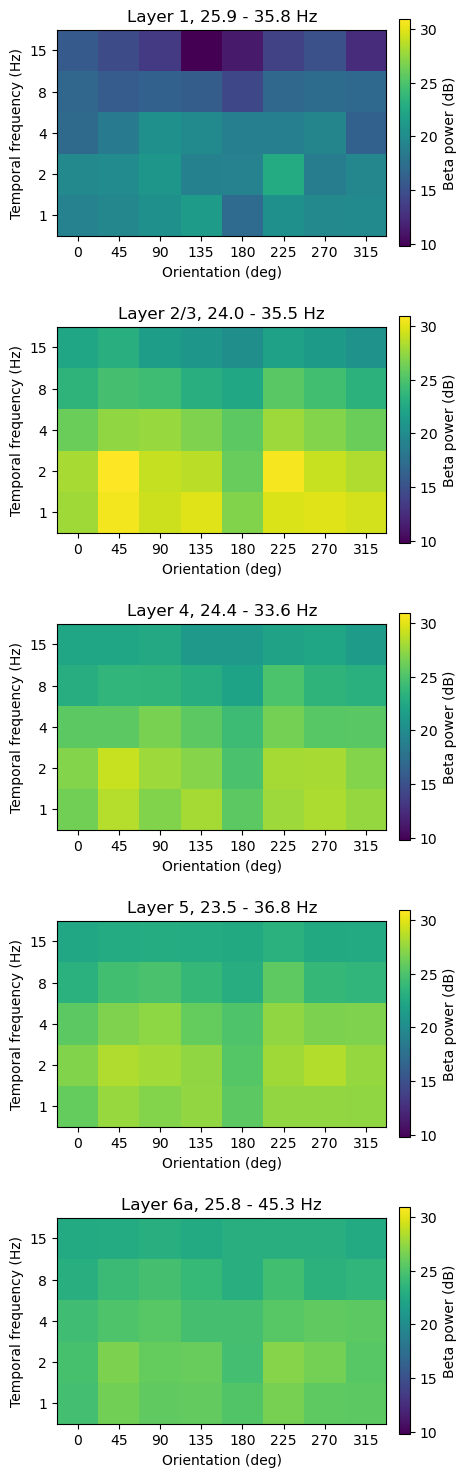

drifting_gratings_75_repeats


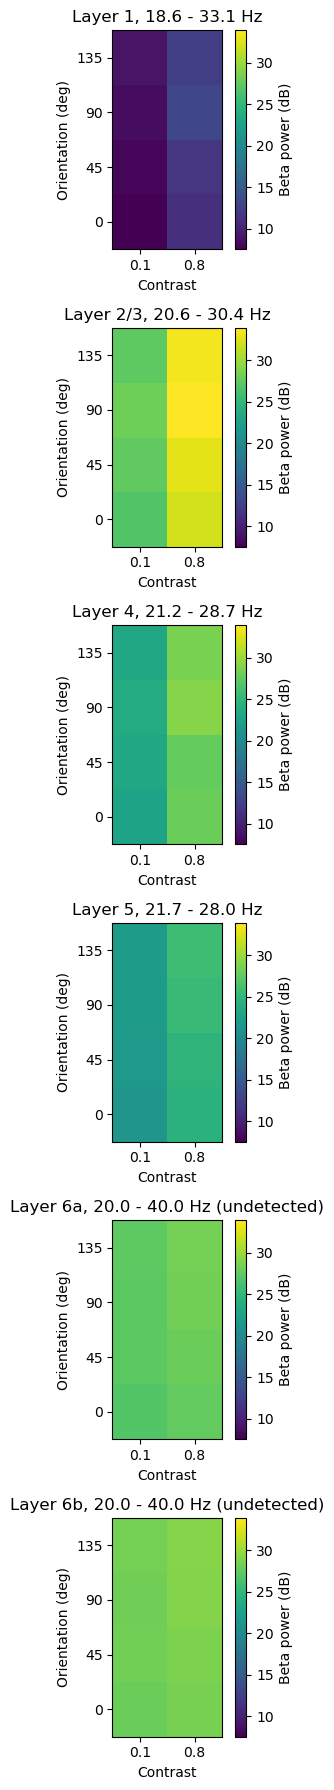

drifting_gratings_contrast


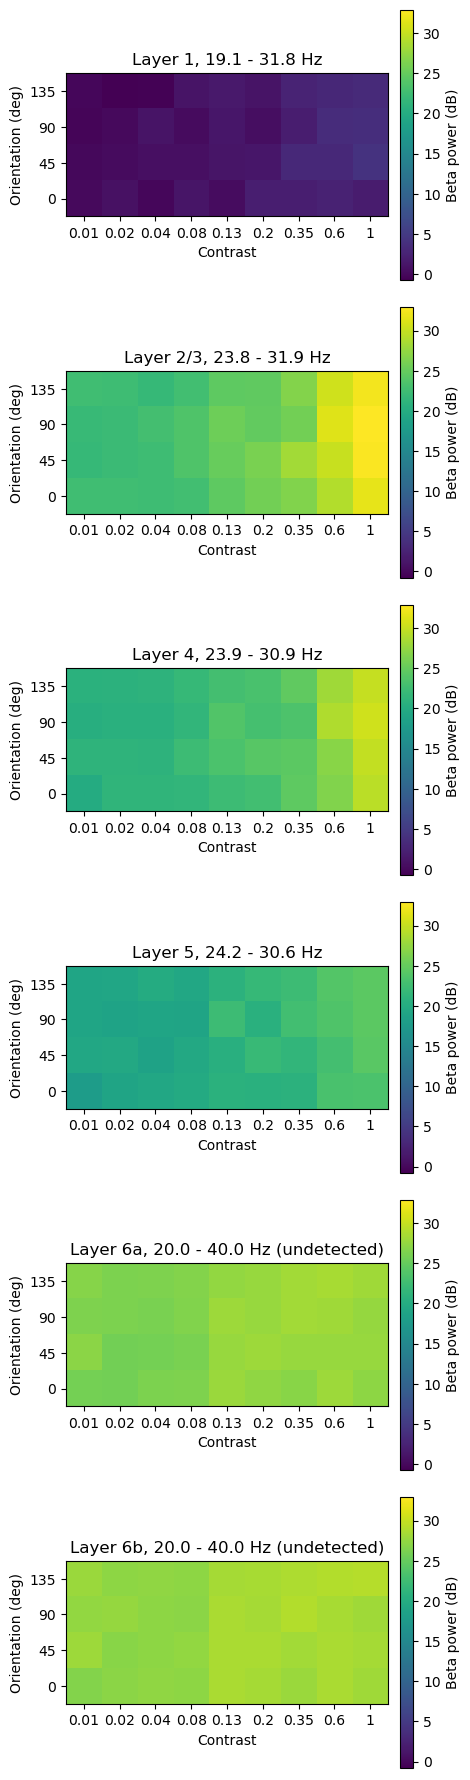

In [15]:
x_cond, y_cond = st.VARIED_CONDITION_TYPES[session_type]

for stim, cond_band_power in cond_band_power_das.items():
    print(stim)
    x_cond, y_cond = st.VARIED_CONDITION_TYPES[st.STIMULUS_SESSION_TYPES[stim]]
    fig, axs = plots.plot_layer_condition_band_power(cond_band_power, layer_bands_ds[stim], x_cond, y_cond)

    if SAVE_FIGURE:
        save_figure(cond_band_power_dir, fig, name=stim)
    plt.show()

### Plot average PSD of stimuli

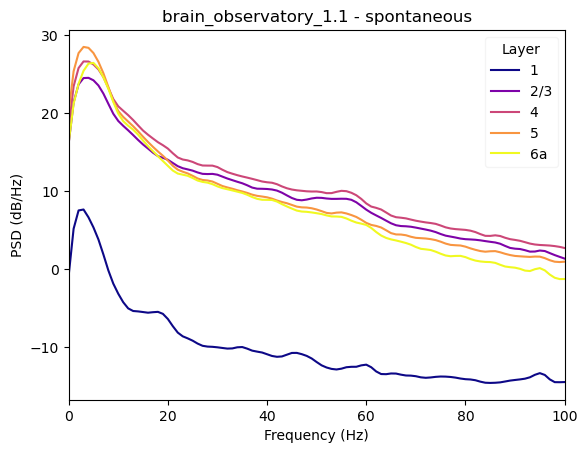

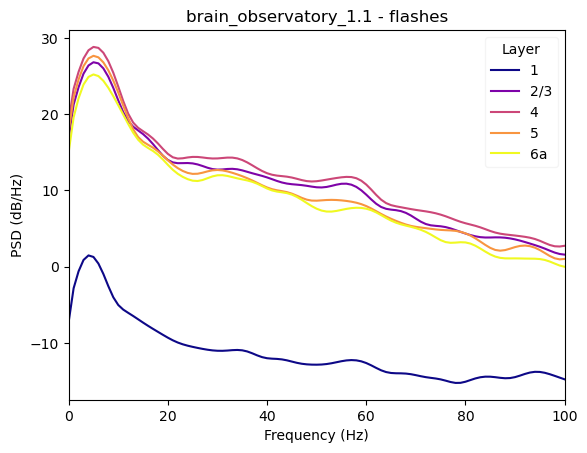

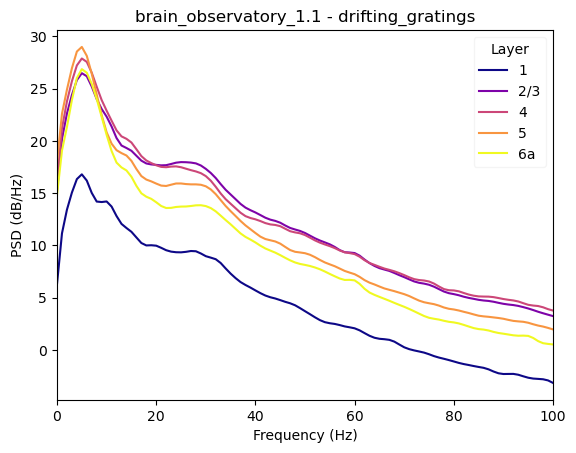

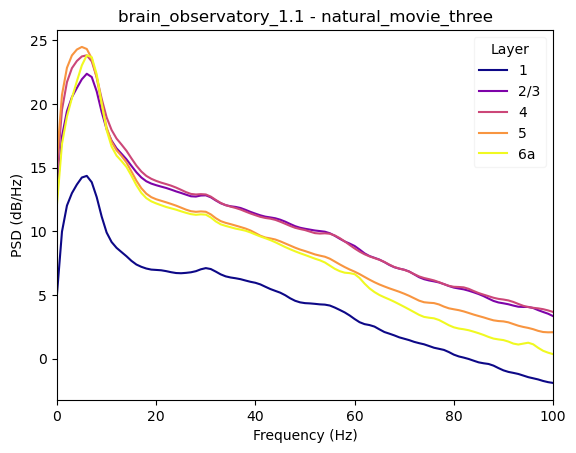

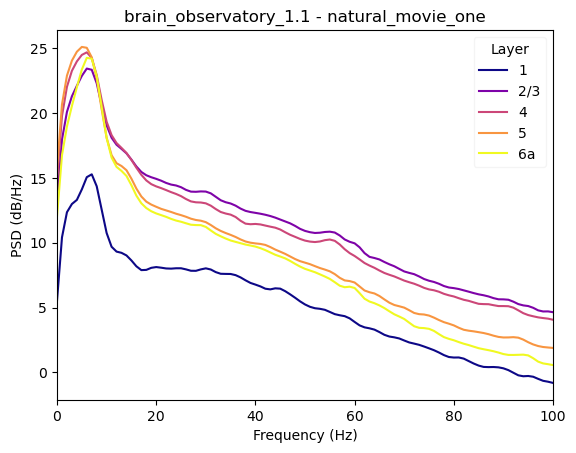

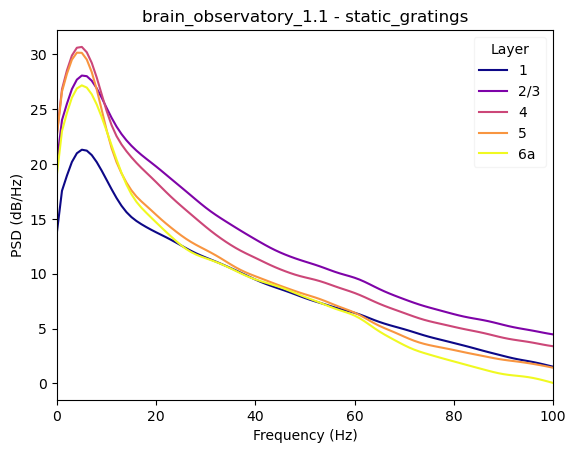

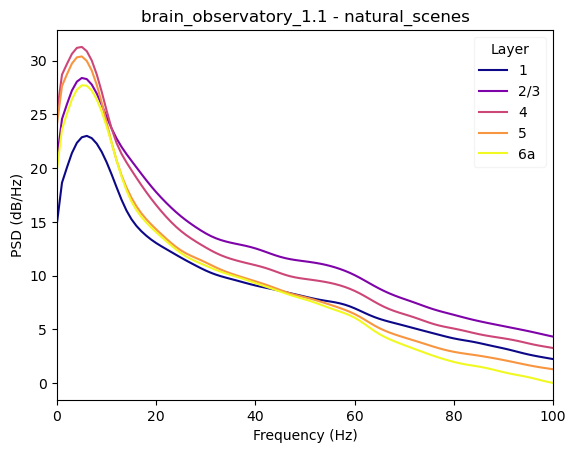

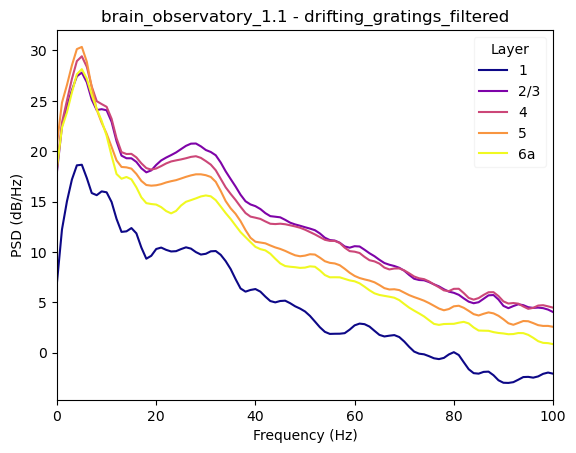

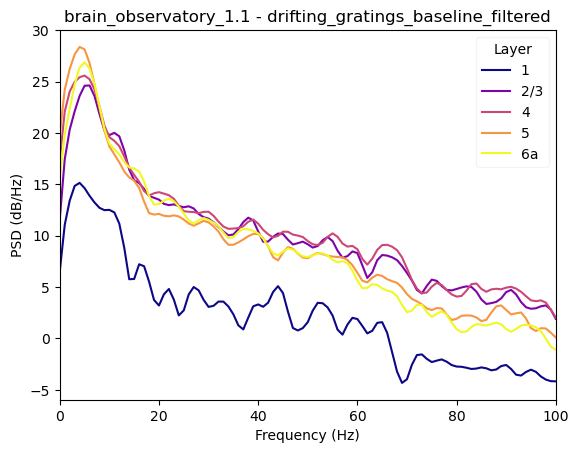

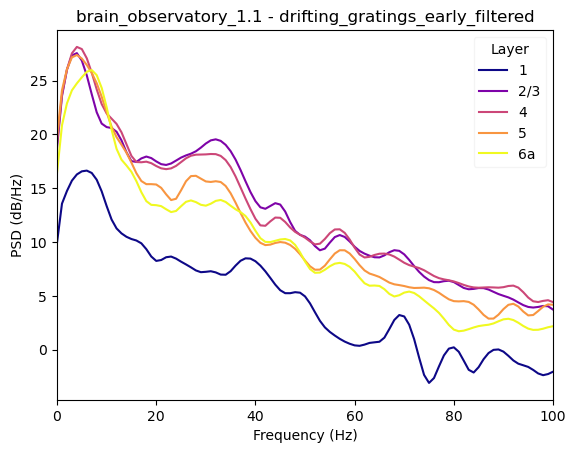

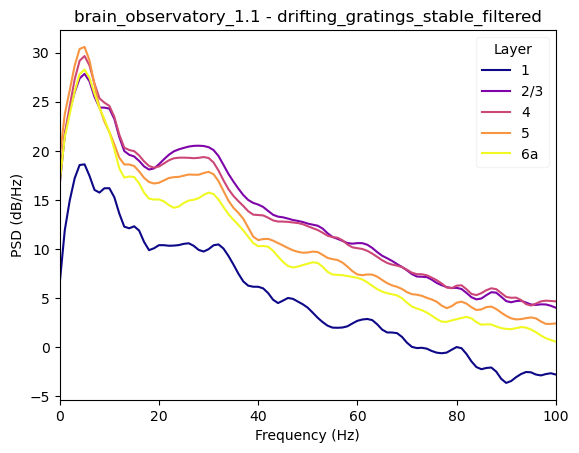

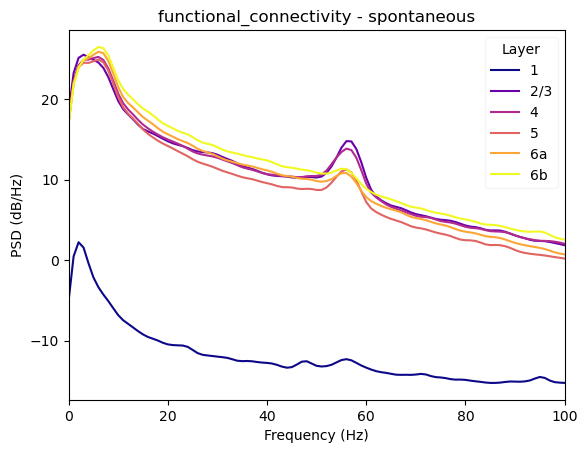

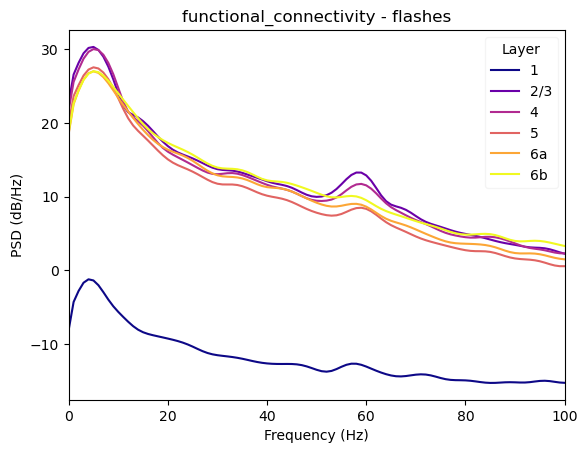

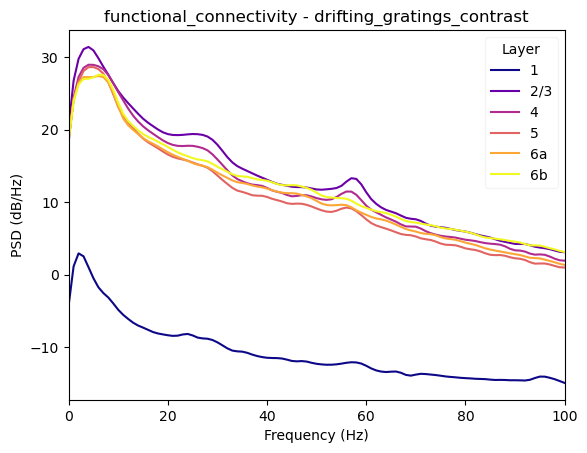

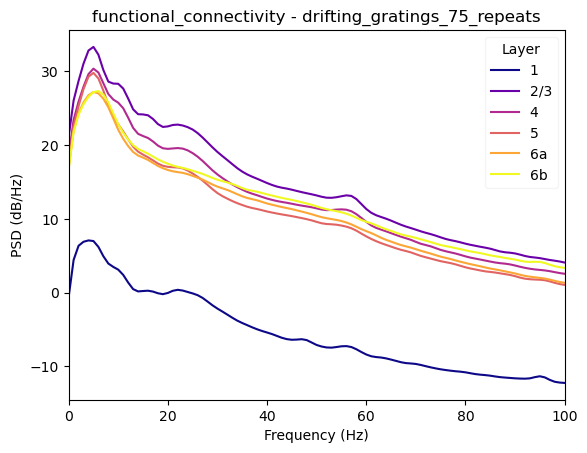

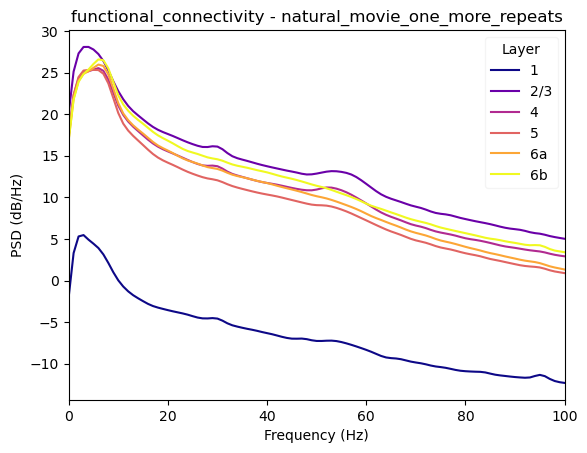

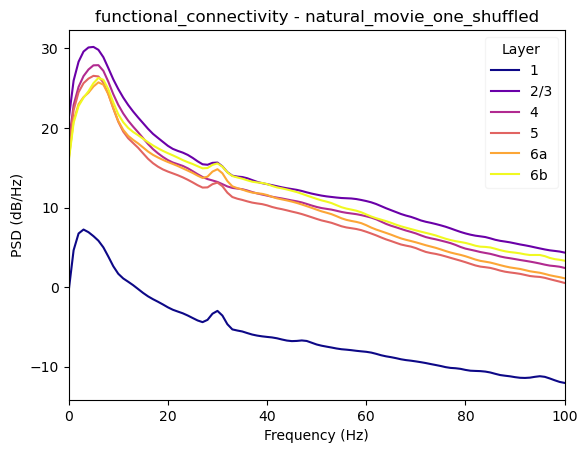

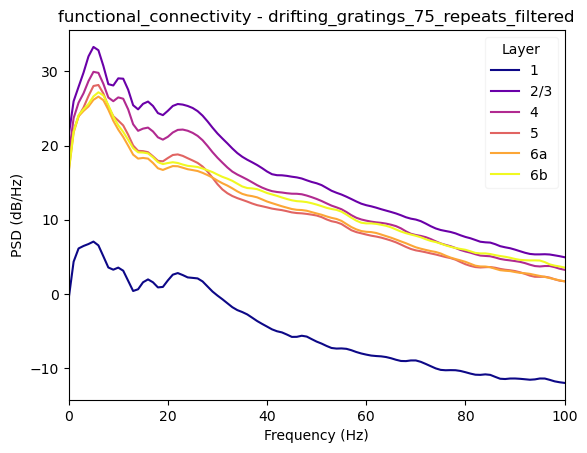

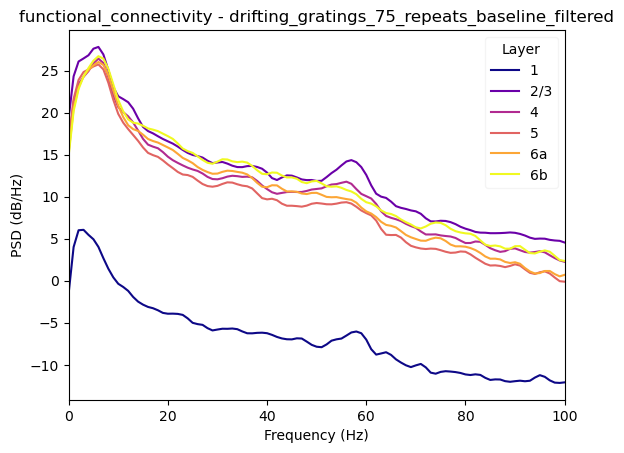

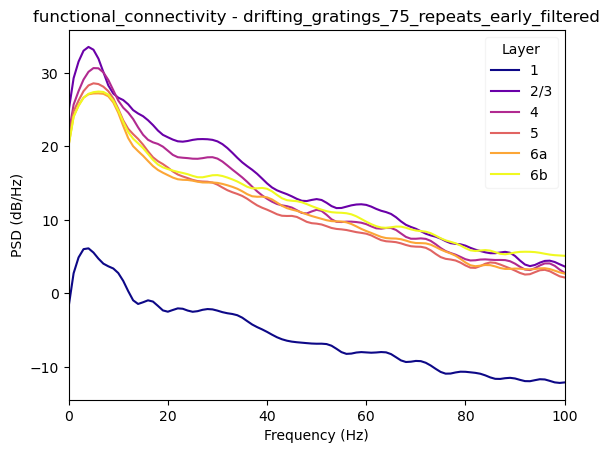

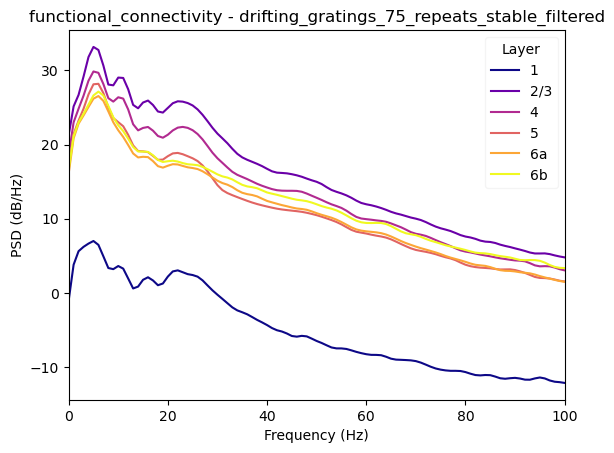

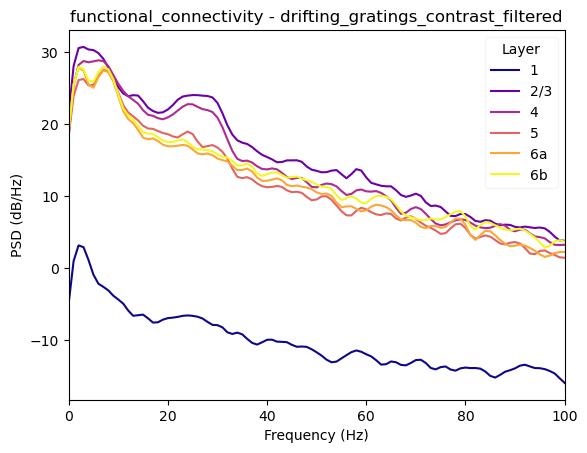

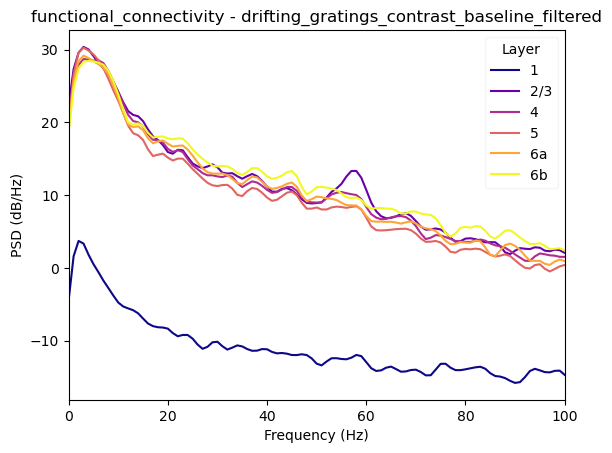

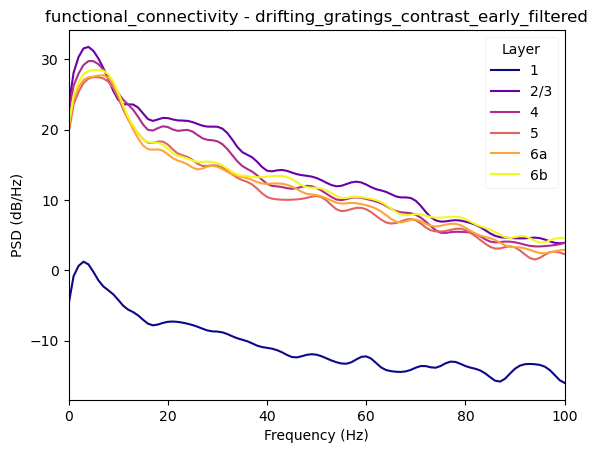

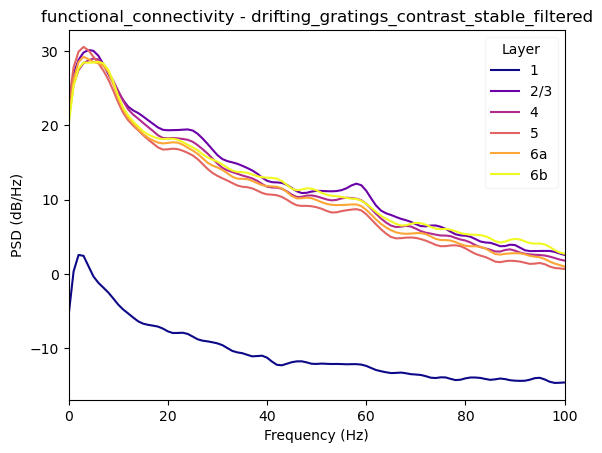

In [16]:
for session_type, psd_avg_ds in psd_avg.items():
    if SAVE_FIGURE:
        layer_psd_dir_ = layer_psd_dir / session_type
        layer_psd_dir_.mkdir(parents=True, exist_ok=True)

    for stim, da in psd_avg_ds.data_vars.items():
        ax = plots.plot_channel_psd(da, channel_dim='layer', freq_range=plt_range)
        ax.set_title(f"{session_type} - {stim}")

        if SAVE_FIGURE:
            fig = ax.get_figure()
            save_figure(layer_psd_dir_, fig, name=f"{session_type}-{stim}")

    plt.show()

In [17]:
if SAVE_FIGURE:
    for session_type, psd_avg_ds in psd_avg.items():
        fooof_dir_ = fooof_dir / session_type
        fooof_dir_.mkdir(parents=True, exist_ok=True)

        for stim in psd_avg_ds.data_vars.keys():
            figs = {}
            for layer in psd_avg_ds.coords['layer'].values:
                fig, ax = plt.subplots(1, 1)
                ax = plots.plot_fooof_quick(fooof_objs[session_type][stim][layer], freq_range=plt_range, ax=ax)

                band = avg_bands_ds[session_type].bands.sel(stimulus=stim, layer=layer)
                ax = plots.plot_freq_band(band, band.wave_band, ax=ax)
                ax.set_title(f"{stim} layer {layer}")

                figs[f"{stim}_layer_{format_for_path(layer)}"] = fig

            save_figure(fooof_dir_, figs)
            plt.close('all')